## 전처리 아이디어

1. 요일 변수, 주말인지 ㅇ
2. 건물별 군집 ㅇ
3. 비가 오는지 -> 오는지 안오는지만 categorical로 분류(강수량은 중요하지 않은건지)
4. 기온이 높은지 ㅇ
5. 밤에 사용량이 많은지(가정집이나 아파트 / 사무용 건물) -> 클러스터와 유사
6. 타 건물 정보(8월 이후 데이터는 비어잇으니까) -> 날짜별 데이터는 없음
7. 평균 기온, 날씨를 활용해 지역 유추 -> 타지역 데이터 필요
+ 날씨가 흐릴때(일조량 적을때) 태양광 활용 건물의 전력량 차이 확인 -> 변수로 묶기?
.
.


8. k-means 외에 다른 클러스터링 방법 활용 -> knn, gmm, svm..? 
9. kmeans 파라미터 조절해서 최적화해보기
10. 다른 모델링 기법 활용
10. 모델링 파라미터 수정
11. 필요없는 변수 삭제

# 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# 맑음 고딕 폰트 설정
plt.rc('font', family='Malgun Gothic') # For Windows
print(plt.rcParams['font.family'])

%matplotlib inline

['Malgun Gothic']


In [3]:
# 데이터 불러오기

directory = './energy'

train = pd.read_csv(directory + '/train.csv', encoding = 'euc-kr')
test = pd.read_csv(directory + '/test.csv', encoding = 'euc-kr')
sample_submission = pd.read_csv(directory + '/sample_submission.csv', encoding = 'euc-kr')

In [4]:
train_columns_name = ['num', 'date_time', 'usage', 'temp', 'wind', 'humidity', 'precipitation', 'sunshine', 'operation_non_elec', 'solar']
test_columns_name = ['num', 'date_time', 'temp', 'wind', 'humidity', 'precipitation', 'sunshine', 'operation_non_elec', 'solar']

train.columns = train_columns_name
test.columns = test_columns_name

# EDA

train dataset

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   num                 122400 non-null  int64  
 1   date_time           122400 non-null  object 
 2   usage               122400 non-null  float64
 3   temp                122400 non-null  float64
 4   wind                122400 non-null  float64
 5   humidity            122400 non-null  float64
 6   precipitation       122400 non-null  float64
 7   sunshine            122400 non-null  float64
 8   operation_non_elec  122400 non-null  float64
 9   solar               122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num                 10080 non-null  int64  
 1   date_time           10080 non-null  object 
 2   temp                3360 non-null   float64
 3   wind                3360 non-null   float64
 4   humidity            3360 non-null   float64
 5   precipitation       1680 non-null   float64
 6   sunshine            3360 non-null   float64
 7   operation_non_elec  2296 non-null   float64
 8   solar               1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


In [7]:
train.head()

,num,date_time,usage,temp,wind,humidity,precipitation,sunshine,operation_non_elec,solar
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [8]:
test.head()

,num,date_time,temp,wind,humidity,precipitation,sunshine,operation_non_elec,solar
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
train.describe()

,num,usage,temp,wind,humidity,precipitation,sunshine,operation_non_elec,solar
count,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
mean,30.500000,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533,0.683333,0.483333
std,17.318173,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517,0.465178,0.499724
min,1.000000,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,15.750000,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000,0.000000,0.000000
50%,30.500000,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000,1.000000,0.000000
75%,45.250000,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000,1.000000,1.000000
max,60.000000,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000,1.000000,1.000000


In [10]:
test.describe()

,num,temp,wind,humidity,precipitation,sunshine,operation_non_elec,solar
count,10080.000000,3360.000000,3360.000000,3360.000000,1680.000000,3360.000000,2296.0,1624.0
mean,30.500000,27.805804,2.440327,81.963095,2.191845,0.612917,1.0,1.0
std,17.318961,2.378122,1.835905,11.900843,6.786772,0.929587,0.0,0.0
min,1.000000,22.100000,0.000000,44.000000,0.000000,0.000000,1.0,1.0
25%,15.750000,26.000000,1.100000,74.000000,0.000000,0.000000,1.0,1.0
50%,30.500000,27.500000,2.100000,83.000000,0.000000,0.000000,1.0,1.0
75%,45.250000,29.200000,3.200000,92.000000,0.900000,1.000000,1.0,1.0
max,60.000000,35.400000,22.500000,100.000000,83.500000,3.000000,1.0,1.0


In [11]:
test.isnull().sum()

num                      0
date_time                0
temp                  6720
wind                  6720
humidity              6720
precipitation         8400
sunshine              6720
operation_non_elec    7784
solar                 8456
dtype: int64

In [12]:
# date_time 변수를 문자형에서 날짜형 변수로 변환

train['date'] =pd.to_datetime(train['date_time'].apply(lambda x: x.split()[0]))
train['date_time'] = pd.to_datetime(train['date_time'])

test['date'] = pd.to_datetime(test['date_time'].apply(lambda x: x.split()[0]))
test['date_time'] = pd.to_datetime(test['date_time'])

# 월, 시간 변수 추가

train['month'] = train['date_time'].dt.month
train['hour'] = train['date_time'].dt.hour
test['month'] = test['date_time'].dt.month
test['hour'] = test['date_time'].dt.hour

## 변수들의 월별 평균

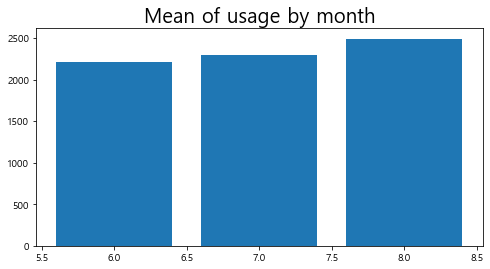

In [13]:
mean_month = train.groupby('month').mean()

plt.figure(figsize=(8,4))
plt.bar(mean_month.index, mean_month['usage'])
plt.title('Mean of usage by month', size = 20)
plt.show()

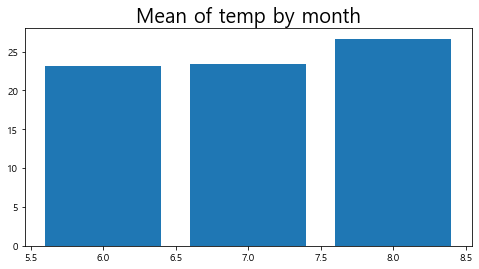

In [14]:
plt.figure(figsize=(8,4))
plt.bar(mean_month.index,mean_month['temp'])
plt.title('Mean of temp by month', size = 20)
plt.show()

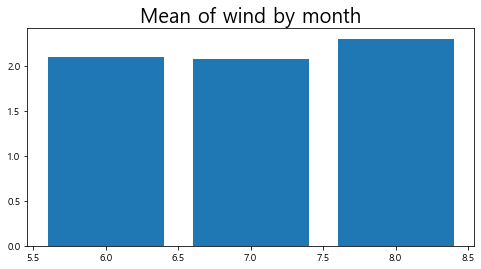

In [15]:
plt.figure(figsize=(8,4))
plt.bar(mean_month.index,mean_month['wind'])
plt.title('Mean of wind by month', size = 20)
plt.show()

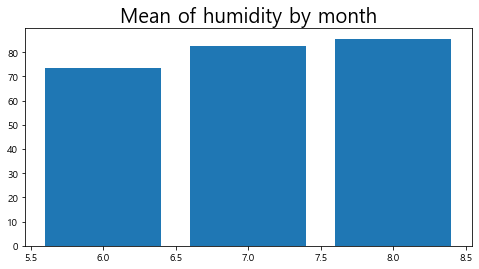

In [16]:
plt.figure(figsize=(8,4))
plt.bar(mean_month.index,mean_month['humidity'])
plt.title('Mean of humidity by month', size = 20)
plt.show()

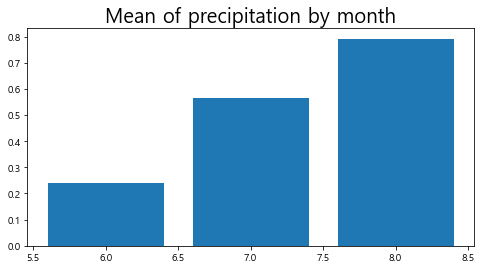

In [17]:
plt.figure(figsize=(8,4))
plt.bar(mean_month.index,mean_month['precipitation'])
plt.title('Mean of precipitation by month', size = 20)
plt.show()

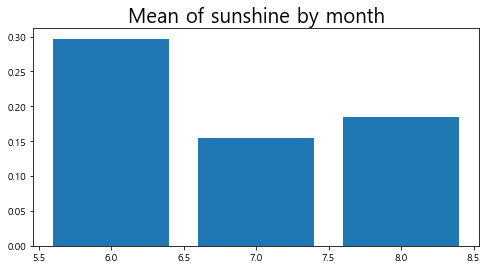

In [18]:
plt.figure(figsize=(8,4))
plt.bar(mean_month.index,mean_month['sunshine'])
plt.title('Mean of sunshine by month', size = 20)
plt.show()

## 시간별 전력사용량

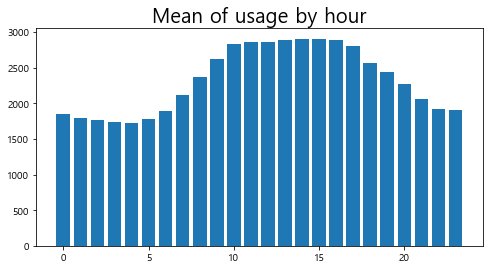

In [19]:
mean_hour = train.groupby('hour').mean()

plt.figure(figsize=(8,4))
plt.bar(mean_hour.index,mean_hour['usage'])
plt.title("Mean of usage by hour", size = 20)
plt.show()

## 건물별 기온

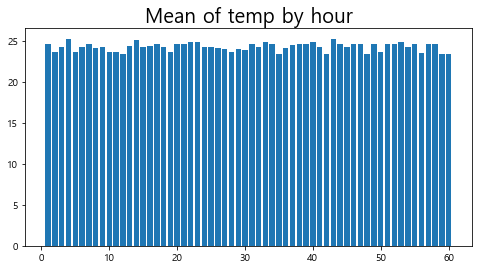

In [20]:
mean_num = train.groupby('num').mean()

plt.figure(figsize=(8,4))
plt.bar(mean_num.index,mean_num['temp'])
plt.title("Mean of temp by hour", size = 20)
plt.show()

## 건물별 풍속

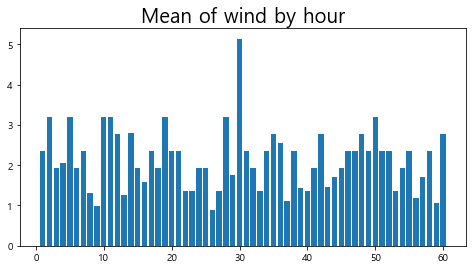

In [21]:
plt.figure(figsize=(8,4))
plt.bar(mean_num.index,mean_num['wind'])
plt.title("Mean of wind by hour", size = 20)
plt.show()

## 날짜별 차이

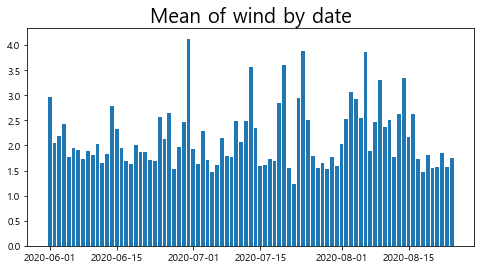

In [22]:
mean_date = train.groupby('date').mean()

plt.figure(figsize=(8,4))
plt.bar(mean_date.index,mean_date['wind'])
plt.title("Mean of wind by date", size = 20)
plt.show()

# 전처리

1. date_time을 날짜형 변수로 변환해 월, 시간 변수 추가

2. 요일 변수, 주말 여부 변수를 정수형 변수로 사용

3. test 데이터의 결측치 대체

4. 건물별 군집번호를 정수형 변수로 사용

In [23]:
# 요일 변수와 주말 여부 변수를 추가, 원핫인코딩 하지 않고 정수형 변수로 사용

# weekday 변수 평일=0~4, 주말=5~6
def weekday(x):
    return pd.to_datetime(x).weekday()

train['weekday']=train['date'].apply(lambda x : weekday(x))
test['weekday']=test['date_time'].apply(lambda x :weekday(x))

# weekend 변수 평일=0, 주말=1
train['weekend']=train['weekday'].apply(lambda x: 0 if x < 4 else 1)
test['weekend']=test['weekday'].apply(lambda x: 0 if x < 4 else 1)

## 결측치 대체

건물별로 비전기냉방설비운영, 태양광보유 여부를 train 데이터로부터 구해서 test 데이터의 결측값을 채워줌

기온, 풍속, 습도, 강수량, 일조 변수는 선형 보간법을 이용해 결측값을 대체

In [24]:
train.head()

,num,date_time,usage,temp,wind,humidity,precipitation,sunshine,operation_non_elec,solar,date,month,hour,weekday,weekend
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01,6,0,0,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01,6,1,0,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,6,2,0,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,6,3,0,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01,6,4,0,0


In [25]:
test.head()

,num,date_time,temp,wind,humidity,precipitation,sunshine,operation_non_elec,solar,date,month,hour,weekday,weekend
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,NaN,NaN,2020-08-25,8,0,1,0
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-25,8,1,1,0
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-25,8,2,1,0
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,NaN,NaN,2020-08-25,8,3,1,0
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-25,8,4,1,0


In [26]:
#건물별로 '비전기냉방설비운영'과 '태양광보유'를 판단해 test set의 결측치를 대체

ice={}
hot={}
count=0

for i in range(0, len(train), len(train)//60):
    count +=1
    ice[count]=train.loc[i,'operation_non_elec']
    hot[count]=train.loc[i,'solar']

for i in range(len(test)):
    test.loc[i, 'operation_non_elec']=ice[test['num'][i]]
    test.loc[i, 'solar']=hot[test['num'][i]]

In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   num                 10080 non-null  int64         
 1   date_time           10080 non-null  datetime64[ns]
 2   temp                3360 non-null   float64       
 3   wind                3360 non-null   float64       
 4   humidity            3360 non-null   float64       
 5   precipitation       1680 non-null   float64       
 6   sunshine            3360 non-null   float64       
 7   operation_non_elec  10080 non-null  float64       
 8   solar               10080 non-null  float64       
 9   date                10080 non-null  datetime64[ns]
 10  month               10080 non-null  int64         
 11  hour                10080 non-null  int64         
 12  weekday             10080 non-null  int64         
 13  weekend             10080 non-null  int64     

In [28]:
# 선형 보간법으로 결측값을 대체
test = test.interpolate(method='values')  
test.head(3)

,num,date_time,temp,wind,humidity,precipitation,sunshine,operation_non_elec,solar,date,month,hour,weekday,weekend
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.0,0.0,0.0,2020-08-25,8,0,1,0
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.0,0.0,0.0,2020-08-25,8,1,1,0
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.0,0.0,0.0,2020-08-25,8,2,1,0


## 건물 군집화

건물별로 요일, 시간별 평균을 계산한 뒤 표준화를 한 다음 Kmeans 군집화를 시행

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

d_list = []
for i in range(1, 61):
    d = train[train['num'] == i].copy()
    d['usage'] = scaler.fit_transform(d['usage'].values.reshape(-1,1))
    d_ = d.groupby(['weekday', 'hour'])['usage'].mean().unstack()
    d_list.append(d_.to_numpy())

# 정규화된 시간-요일별 전력사용량을 이미지처럼 저장
d_list = np.array(d_list)

In [ ]:
d_list_ = d_list.reshape(60, -1)

# 군집 개수를 4개로 설정
model = KMeans(init="k-means++", n_clusters=4, random_state=0)
model.fit(d_list_)

KMeans(n_clusters=4, random_state=0)

In [ ]:
cluster = model.labels_
pd.DataFrame(cluster).squeeze().value_counts()

1    31
2    17
3     7
0     5
Name: 0, dtype: int64

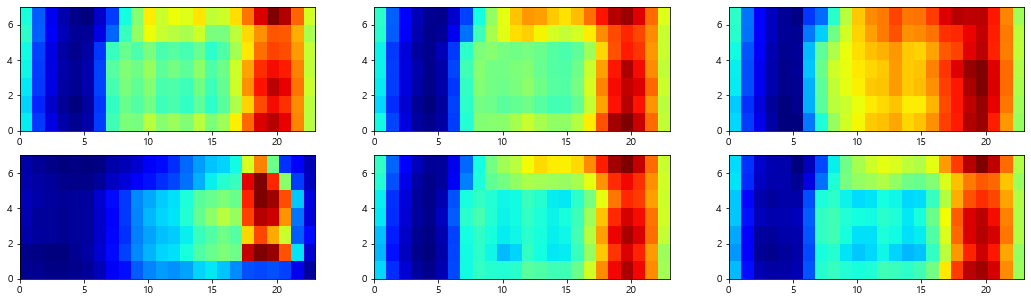

In [ ]:
idx = cluster == 3
d_list = d_list.reshape(60, 7, 24)


fig, axes = plt.subplots(2, int(len(d_list[idx])/2), figsize = (18, 5))
axes = axes.flatten()

for d, ax in zip(d_list[idx], axes):
    d_ = scaler.inverse_transform(d)
    
    ax.imshow(d_, cmap = 'jet', aspect = 'auto', extent=[0, 23, 0, 7], origin = 'lower')

In [ ]:
# 군집 번호를 변수로 추가

cluster_map = {i+1 : c for i, c in enumerate(cluster)}
train['cluster'] = train['num'].map(cluster_map)
test['cluster'] = test['num'].map(cluster_map)

# 모델링

## XGBOOST

In [ ]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [ ]:
# train, validation, test 데이터 분할
from sklearn.model_selection import train_test_split

X = train.drop(['date_time', '전력사용량(kWh)','date'], axis = 1)
y = train['전력사용량(kWh)']
X_test = test.drop(['date_time','date'], axis = 1)

x_train, x_val, y_train, y_val = train_test_split(X, y, random_state=49)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_val_score

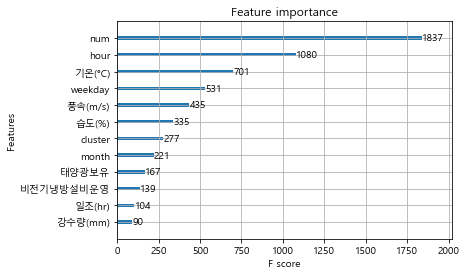

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=666)
model.fit(x_train, y_train)
preds = model.predict(x_val)
xgboost.plot_importance(model)

In [ ]:
r_sq = model.score(x_train, y_train)
print(r_sq)
print(explained_variance_score(preds,y_val))

0.9855389138522291
0.9811301362771127


In [ ]:
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error')
rmae_scores = np.sqrt(-1*scores)
avg_rmae = np.mean(rmae_scores)

print('5 folds의 개별 Neg MAE scores: ',np.round(scores,2))
print('5 folds의 개별 RMAE scores: ',np.round(rmae_scores,2))
print('5 folds의 평균 RMAE : {0:.3f} '.format(avg_rmae))

5 folds의 개별 Neg MAE scores:  [-2921.37 -1639.37 -2356.54 -2477.58 -2221.34]
5 folds의 개별 RMAE scores:  [54.05 40.49 48.54 49.78 47.13]
5 folds의 평균 RMAE : 47.998 


In [ ]:
from xgboost import XGBRegressor

parameters = {
    'max_depth': [4, 5, 6],
    'n_estimators': [70,  90, 120],
    'learning_rate': [0.01, 0.1], 
    'gamma': [0.01, 0.1,0.95]
}

estimator = XGBRegressor(random_state=666,eval_metric= 'mape')
clf = GridSearchCV(estimator, parameters, verbose=10)
clf.fit(x_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=70 ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=70, score=-0.058, total=   1.3s
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=70 ....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=70, score=-0.053, total=   1.3s
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=70 ....


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=70, score=-0.066, total=   1.3s
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=70 ....


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s


[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=70, score=-0.070, total=   1.4s
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=70 ....


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.2s remaining:    0.0s


[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=70, score=-0.059, total=   1.3s
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=90 ....


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.6s remaining:    0.0s


[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=90, score=0.093, total=   1.6s
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=90 ....


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    8.2s remaining:    0.0s


[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=90, score=0.097, total=   1.8s
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=90 ....


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   10.0s remaining:    0.0s


[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=90, score=0.086, total=   1.7s
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=90 ....


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.7s remaining:    0.0s


[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=90, score=0.085, total=   1.7s
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=90 ....


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   13.4s remaining:    0.0s


[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=90, score=0.099, total=   1.7s
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=120 ...
[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=120, score=0.262, total=   2.3s
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=120 ...
[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=120, score=0.263, total=   2.2s
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=120 ...
[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=120, score=0.257, total=   2.4s
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=120 ...
[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=120, score=0.254, total=   2.4s
[CV] gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=120 ...
[CV]  gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=120, score=0.265, total=   2.3s
[CV] gamma=0.01, learning_rate=0.01, max_depth=5, n_estimators=70 ....

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  9.9min finished


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, eval_metric='mape',
                                    gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=666,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                               

In [ ]:
grid_search_params = clf.best_params_
grid_search_params['random_state'] = 666
grid_search_params

{'gamma': 0.01,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 120,
 'random_state': 666}

In [ ]:
grid_xgb = XGBRegressor(**grid_search_params)
scores=cross_val_score(grid_xgb, X, y, scoring='neg_mean_absolute_error')
rmae_scores=np.sqrt(-1*scores)
avg_rmae=np.mean(rmae_scores)

print('5 folds의 개별 Neg MAE scores: ',np.round(scores,2))
print('5 folds의 개별 RMAE scores: ',np.round(rmae_scores,2))
print('5 folds의 평균 RMAE : {0:.3f} '.format(avg_rmae))

5 folds의 개별 Neg MAE scores:  [-1833.17  -770.92 -1422.48  -998.98 -1134.99]
5 folds의 개별 RMAE scores:  [42.82 27.77 37.72 31.61 33.69]
5 folds의 평균 RMAE : 34.719 


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=666)
model.fit(x_train, y_train)
preds = model.predict(x_val)

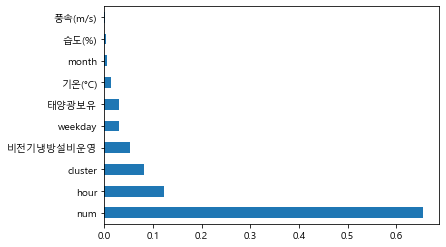

In [ ]:
feat_importances = pd.Series(model.feature_importances_,index=x_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               cv=2,
                               n_iter = 5,
                               verbose=10,
                               random_state=42)

rf_random.fit(X, y)

rf_random.best_params_

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, score=-1.336, total=  15.0s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.9s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, score=-0.543, total=  14.0s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.9s remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=-1.215, total=  55.8s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=-0.573, total=  56.7s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.4min remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False, score=-2.703, total= 3.6min
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.0min remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False, score=-3.583, total= 3.7min
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  9.7min remaining:    0.0s


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, score=-1.280, total= 1.9min
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 11.6min remaining:    0.0s


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, score=-0.586, total= 1.9min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 13.5min remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False, score=-2.701, total= 5.5min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 18.9min remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False, score=-3.604, total= 5.6min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 24.6min finished


{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [ ]:
best_random = rf_random.best_estimator_
preds=best_random.predict(x_val)

In [ ]:
grid_rf = rf_random.best_estimator_
scores=cross_val_score(grid_rf, X, y, scoring='neg_mean_absolute_error')
rmae_scores=np.sqrt(-1*scores)
avg_rmae=np.mean(rmae_scores)

print('5 folds의 개별 Neg MAE scores: ',np.round(scores,2))
print('5 folds의 개별 RMAE scores: ',np.round(rmae_scores,2))
print('5 folds의 평균 RMAE : {0:.3f} '.format(avg_rmae))

5 folds의 개별 Neg MAE scores:  [-1946.19  -843.73 -1478.92 -1265.19 -1033.34]
5 folds의 개별 RMAE scores:  [44.12 29.05 38.46 35.57 32.15]
5 folds의 평균 RMAE : 35.867 


## dacon website test score

Random Forest : 8.762309844

Xgboost : 8.832182239